<a href="https://colab.research.google.com/github/MedicalImageAnalysisTutorials/MutualInformationTutorial/blob/master/IA_Mutual_information_as_an_image_matching_metric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: Matthew Brett https://matthew-brett.github.io/teaching/mutual_information.html

I just converted the post to colab for simpler practice (with simple modification)

Your feedback and corrections are more than welcome!

# Introduction

In which we look at the mutual information measure for comparing images.

When the images to match are the same modality and are well aligned, the signal should be similar in corresponding voxels. In that case, a metric like correlation is useful as a measure of how well the images are matched.

If images are of different modalities, they may well have different signal intensities for the same tissue.

For example, T1-weighted MRI images have low signal in the cerebro-spinal fluid (CSF), but T2-weighted images have high signal in the CSF.

When the T1 and T2 images are well aligned, the voxels containing CSF will correspond spatially, but they will have very different signal. In that case a simple measure like correlation will not capture how well the two images are matched.

Mutual information is a measure of image matching, that does not require the signal to be the same in the two images. It is a measure of how well you can predict the signal in the second image, given the signal intensity in the first.

First let us look at a T1 and T2 image. In fact these images are from the Montreal Neurological Institute (MNI) standard brain atlas : http://www.bic.mni.mcgill.ca/ServicesAtlases/ICBM152NLin2009. See the LICENSE file for copyright and usage of these images.

In [3]:
# Setup
!pip install SimpleITK 
!wget https://github.com/yeatmanlab/AFQ/raw/master/templates/mni_icbm152_nlin_asym_09a_nifti/mni_icbm152_t1_tal_nlin_asym_09a.nii
!wget https://github.com/yeatmanlab/AFQ/raw/master/templates/mni_icbm152_nlin_asym_09a_nifti/mni_icbm152_t2_tal_nlin_asym_09a.nii

     |████████████████████████████████| 48.4 MB 32 kB/s 
--2021-08-26 17:15:21--  https://github.com/yeatmanlab/AFQ/raw/master/templates/mni_icbm152_nlin_asym_09a_nifti/mni_icbm152_t1_tal_nlin_asym_09a.nii
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yeatmanlab/AFQ/master/templates/mni_icbm152_nlin_asym_09a_nifti/mni_icbm152_t1_tal_nlin_asym_09a.nii [following]
--2021-08-26 17:15:21--  https://raw.githubusercontent.com/yeatmanlab/AFQ/master/templates/mni_icbm152_nlin_asym_09a_nifti/mni_icbm152_t1_tal_nlin_asym_09a.nii
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17350930 (17M) [application

          t1 left, t2 right
          t1 left, t2 right


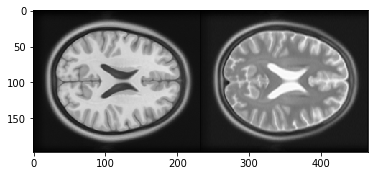

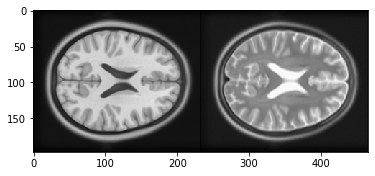

In [4]:
# - compatibility with Python 2
from __future__ import print_function  # print('me') instead of print 'me'
from __future__ import division  # 1/2 == 0.5, not 0
# - import common modules
import os
from math import log2

import numpy as np  # the Python array package

# medical image libs
import nibabel as nib
import SimpleITK as sitk 

# plotting lib
import matplotlib.pyplot as plt  # the Python plotting package
# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

t1_img = nib.load('mni_icbm152_t1_tal_nlin_asym_09a.nii')
t1_data = t1_img.get_fdata()
t2_img = nib.load('mni_icbm152_t2_tal_nlin_asym_09a.nii')
t2_data = t2_img.get_fdata()
 # Show the images by stacking them left-right with hstack
t1_slice = t1_data[:, :, 94]
t2_slice = t2_data[:, :, 94]
plt.imshow(np.hstack((t1_slice, t2_slice)))
print ("          t1 left, t2 right")

# using SimpleITK
fixedPath  = "mni_icbm152_t1_tal_nlin_asym_09a.nii"
movingPath = "mni_icbm152_t2_tal_nlin_asym_09a.nii"

f3d = sitk.GetArrayFromImage(sitk.ReadImage(fixedPath))
m3d = sitk.GetArrayFromImage(sitk.ReadImage(movingPath))

f = np.rot90(f3d[94, :, :])
m = np.rot90(m3d[94, :, :])
plt.figure()
plt.imshow(np.hstack((f, m)))
print ("          t1 left, t2 right")

# Image Histogram and Joint Histogram

The one-dimensional histograms of the example slices then plotting the signal in the T1 slice against the signal in the T2 slice.






Text(0.5, 1.0, 'T2 slice histogram')

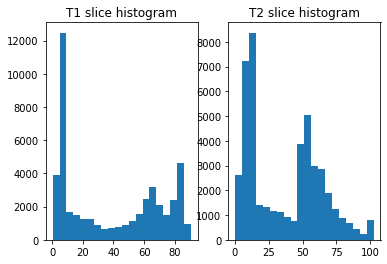

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].hist(t1_slice.ravel(), bins=20)
axes[0].set_title('T1 slice histogram')
axes[1].hist(t2_slice.ravel(), bins=20)
axes[1].set_title('T2 slice histogram')

corrcoef =    0.78707985510953


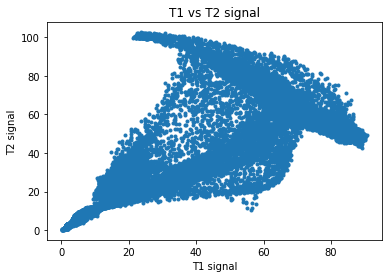

In [ ]:
plt.plot(t1_slice.ravel(), t2_slice.ravel(), '.')
plt.xlabel('T1 signal')
plt.ylabel('T2 signal')
plt.title('T1 vs T2 signal')
print("corrcoef =   ", np.corrcoef(t1_slice.ravel(), t2_slice.ravel())[0, 1])

Notice that we can predict the T2 signal given the T1 signal, but it is not a linear relationship. For example, for T1 signal between 20 and 30, most corresponding T2 signal is low, but there is some T2 signal that is high. This pairing of high T2 signal with low T1 signal is from the CSF, which is dark (low signal) in the T1, and bright in the T2.


Text(0.5, 1.0, 'T2 slice')

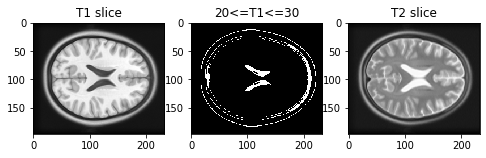

In [ ]:
# Array that is True if T1 signal >= 20, <= 30, False otherwise
t1_20_30 = (t1_slice >= 20) & (t1_slice <= 30)
# Show T1 slice, mask for T1 between 20 and 30, T2 slice
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
axes[0].imshow(t1_slice)
axes[0].set_title('T1 slice')
axes[1].imshow(t1_20_30)
axes[1].set_title('20<=T1<=30')
axes[2].imshow(t2_slice)
axes[2].set_title('T2 slice')

We can capture this more complicated relationship by doing a 2D histogram. This is a histogram that divides the scatterplot into squares, and counts the number of observations inside each square.

Look again at the scatterplot for the T1 and T2 values. We get the 1D histogram for T1 values by splitting the x axis into bins, and taking the number of observations contained in each column defined by the bins. The T2 histogram comes from splitting the y axis into bins and taking the number of observations contained in each row defined by the bins. The 2D histogram comes from dividing both the x and the y axis into bins and taking the number of observations in each square defined by the intersection of the rows and columns.

Numpy has a function for doing the 2D histogram calculation



Text(0.5, 1.0, 'T1 vs T2 signal')

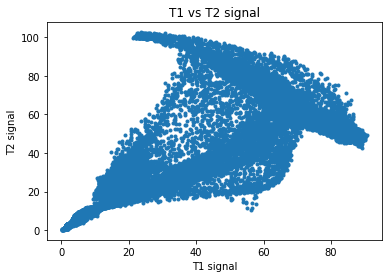

In [ ]:
plt.plot(t1_slice.ravel(), t2_slice.ravel(), '.')
plt.xlabel('T1 signal')
plt.ylabel('T2 signal')
plt.title('T1 vs T2 signal')

[2538. 1365.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.]


Text(0, 0.5, 'T2 signal bin')

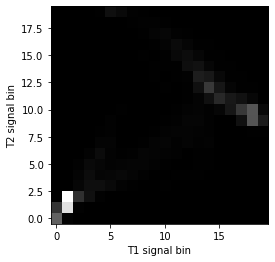

In [ ]:
hist_2d, x_edges, y_edges = np.histogram2d(t1_slice.ravel(),t2_slice.ravel(),bins=20)
# Plot as image, arranging axes as for scatterplot
# We transpose to put the T1 bins on the horizontal axis
# and use 'lower' to put 0, 0 at the bottom of the plot
plt.imshow(hist_2d.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')

The histogram is easier to see if we show the log values to reduce the effect of the bins with a very large number of values:



Text(0, 0.5, 'T2 signal bin')

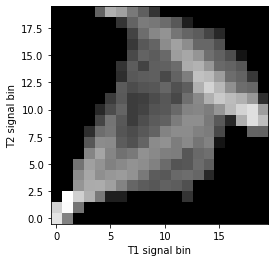

In [ ]:
# Show log histogram, avoiding divide by 0
hist_2d_log = np.zeros(hist_2d.shape)
non_zeros = hist_2d != 0
hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
plt.imshow(hist_2d_log.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')


## Implementing Histogram

In [25]:
def ia_histogram(image,bins=20):
    # Manually computes histogram of an image
    # Error handling
    assert(image.ndim==2),"The function mbHistogram2() can only find an histogram of a 2D array. Check the dimensions of input array."
    assert(bins>0),"The number of bins should be a positive integer."
    
    # Finding maximum and minimum intensity in the image
    binL = np.min(image)
    binU = np.max(image)
    
    # Finding rows and columns in an image
    [rowMax, colMax] = image.shape
    
    # Finding edges of the bins
    bin_edges = np.linspace(binL,binU,bins+1)
    bin_edges=np.array(bin_edges,dtype=np.float32)
    
    # Creating an empty histogram 2D array
    hist = np.zeros(bins)
   
    for row in range(rowMax):
        for col in range(colMax):
            intensity = image[row,col]

            binNo=np.searchsorted(bin_edges,intensity,side='right')
            binNo=binNo-1
            if intensity == bin_edges[-1]:
                binNo=binNo-1

            hist[binNo] = hist[binNo]+1          
    return hist, bin_edges


# Comparing two methods
hist,bin_edges = np.histogram(f,20)
hist2, bin_edges2 = ia_histogram(f,20)

print(np.sum(bin_edges-bin_edges2))
print(np.sum(hist-hist2))

0.0
0.0


## Implementing Joint Histogram:


In [26]:
import os
# def ia_histogram2d(a,b,bins=20):
    
#     return hist2d



def ia_histogram2d(f,m,bins=20):
    # Manually compute joint-histogram of two images
    # input two 2d images f,m 
    # output two square array of size [bins,bins]
    # the first array is 2d histogram
    # second array is logarithmec 2d histogram (for visualisation)
    
    # Error handling
    assert(f.ndim==2),"The function mbHistogram2() can only find an histogram of 2D arrays. Check the dimensions of input array."
    assert(m.ndim==2),"The function mbHistogram2() can only find an histogram of 2D arrays. Check the dimensions of input array."
    assert(f.shape==m.shape),"Dimesions of the input array do not match."
    
    # Finding maximum and minimum intensities present in the two images
    [binL1,binU1] = [np.min(f), np.max(f)]
    [binL2,binU2] = [np.min(m), np.max(m)]
    
    # Finding rows and columns in an image
    [rowMax, colMax] = f.shape
    
    # Finding edges of the bins
    bin_edgesX = np.linspace(binL1,binU1,bins+1)
    bin_edgesX = np.array(bin_edgesX,dtype=np.float64)
    bin_edgesY = np.linspace(binL2,binU2,bins+1)
    bin_edgesY = np.array(bin_edgesY,dtype=np.float64)
    
    # Creating an empty histogram 2D array
    jhist = np.zeros(shape=(bins,bins))
    
    for row in range(rowMax):
        for col in range(colMax):
            # Finding bin in X-direction
            intensity1 = f[row,col]
            binX=np.searchsorted(bin_edgesX,intensity1,side='right')
            binX=binX-1
            if intensity1 == bin_edgesX[-1]: #making sure to include highest element in the last bin
                binX = binX-1
    
            # Finding bin in Y-direction
            intensity2 = m[row,col]
            binY=np.searchsorted(bin_edgesY,intensity2,side='right')
            binY=binY-1
            if intensity2 == bin_edgesY[-1]: #making sure to include highest element in the last bin
                binY = binY-1
                
            jhist[binX,binY] = jhist[binX,binY]+1    
    
    #get log for visualization
    jhistl= np.zeros(jhist.shape)
    non_zeros = jhist != 0
    jhistl[non_zeros] = np.log(jhist[non_zeros])
    return jhist,jhistl


jh, jhl= ia_histogram2d(t1_slice,t2_slice,30)
jh2, x_edges, y_edges  = np.histogram2d(t1_slice.ravel(),t2_slice.ravel(),bins=30)

#test
temp = jh2-jh
print(np.sum(temp))

0.0


# Probability, Joint Probability, and Conditional Probality

source: [A Gentle Introduction to Joint, Marginal, and Conditional Probability](https://machinelearningmastery.com/joint-marginal-and-conditional-probability-for-machine-learning/)

Probability quantifies the uncertainty of the outcomes of a random variable. It is relatively easy to understand and compute the probability for a single variable. Nevertheless, in machine learning, we often have many random variables that interact in often complex and unknown ways.

There are specific techniques that can be used to quantify the probability for multiple random variables, such as the joint, marginal, and conditional probability.  




## Probability of One Random Variable

Probability quantifies the likelihood of an event. Specifically, it quantifies how likely a specific outcome is for a random variable, such as the flip of a coin, the roll of a dice, or drawing a playing card from a deck.

For a random variable $x$, $p(x)$ is a function that assigns a probability to all values of x.

* Probability Density of x = p(x)

The probability of a specific event A for a random variable x is denoted as $p(x=A)$, or simply as $p(A)$.

* Probability of Event A = p(A)

Probability is calculated as the number of desired outcomes divided by the total possible outcomes, in the case where all outcomes are equally likely.

$$
Probability = \frac{\text{number of desired outcomes}}{\text{total number of possible outcomes}}
$$

This is intuitive if we think about a discrete random variable such as the roll of a dice. 

For example, the probability of a dice rolling a 5 is or about 16.666%.calculated as:
$$
 \frac{\text{one outcome of rolling a 5}}{\text{divided by the total number of discrete outcomes}}=\frac{1}{6}= 0.1666 
$$


The sum of the probabilities of all outcomes must equal one. If not, we do not have valid probabilities.

 * Sum of the Probabilities for All Outcomes = 1.0.

The probability of an impossible outcome is zero. For example, it is impossible to roll a 7 with a standard six-sided dice.

* Probability of Impossible Outcome = 0.0

The probability of a certain outcome is one. For example, it is certain that a value between 1 and 6 will occur when rolling a six-sided dice.

* Probability of Certain Outcome = 1.0

The probability of an event not occurring, called the complement. This can be calculated by one minus the probability of the event, or $1 – p(A)$. For example, the probability of not rolling a 5 would be $1 – p(5)$ or $1 – 0.166$ or about 0.833 or about 83.333%.

* Probability of Not Event A = 1 – p(A)

Now that we are familiar with the probability of one random variable, let’s consider probability for multiple random variables.


## Probability of Multiple Random Variables

 We are likely to work with many random variables. For example, given a table of data, such as in excel, each row represents a separate observation or event, and each column represents a separate random variable.

Variables may be either discrete, meaning that they take on a finite set of values, or continuous, meaning they take on a real or numerical value.

As such, we are interested in the probability across two or more random variables.

This is complicated as there are many ways that random variables can interact, which, in turn, impacts their probabilities.

This can be simplified by reducing the discussion to just two random variables (X, Y), although the principles generalize to multiple variables.

And further, to discuss the probability of just two events, one for each variable (X=A, Y=B), although we could just as easily be discussing groups of events for each variable.

Therefore, we will introduce the probability of multiple random variables as the probability of event A and event B, which in shorthand is X=A and Y=B.

We assume that the two variables are related or dependent in some way.

As such, there are three main types of probability we might want to consider; they are:

* Joint Probability: Probability of events A and B.
* Marginal Probability: Probability of event X=A given variable Y.
* Conditional Probability: Probability of event A given event B.


For example:

* The probability of a row of data is the joint probability across each input variable.
* The probability of a specific value of one input variable is the marginal probability across the values of the other input variables.
* The predictive model itself is an estimate of the conditional probability of an output given an input example.



## Joint Probability of Two Variables

We may be interested in the probability of two simultaneous events, e.g. the outcomes of two different random variables.

The probability of two (or more) events is called the joint probability. The joint probability of two or more random variables is referred to as the joint probability distribution.

For example, the joint probability of event A and event B is written formally as:

 * $p(A \text{ and } B) = p(A,B) = p(A \cap B) $ 

The joint probability for events A and B is calculated as the probability of event A given event B multiplied by the probability of event B.

$$
p(A,B) = p(A|B) p(B)
$$

The calculation of the joint probability is sometimes called the fundamental rule of probability or the “product rule” of probability or the “chain rule” of probability.

Here, p(A|B)=p(A given B) is the probability of event A given that event B has occurred, called the conditional probability, described below.

The joint probability is symmetrical, meaning that P(A and B) is the same as P(B and A). The calculation using the conditional probability is also symmetrical, for example:

$$
p(A,B) = p(A|B) p(B) = p(B|A) p(A)
$$


A good tutorial can be found [here](https://www.investopedia.com/terms/j/jointprobability.asp).


If the events are independent: 

$$
p(A,B) = p(A \cap B) = p(A)p(B)
$$

An example: drawing the (red and six) cards of from a [deck of cards](https://en.wikipedia.org/wiki/Standard_52-card_deck) 


$p(x) = p(6) = \frac{4}{52} = 0.0769$

$p(y) = p(red) = \frac{26}{52}= 0.5$

$p(x|y) = p(6|red) = \frac{2}{26} = 0.0769 \quad$ we have 2 cards of "6" in 26 red cards 

$p(y|x) = p(red|6) = \frac{2}{4}  = 0.5 \quad$ we have 2 red cards in 4 cards of "6"

$p(x,y) = p(6,red) = p(6 \cap red) = p(6)p(red) = (\frac{4}{52})(\frac{26}{52}) = \frac{1}{26}$

$ p(x|y) = p(6|red) = p(6,red)/p(red) = (\frac{1}{26})\frac{52}{26}=\frac{1}{13} =0.0769$

$ p(y|x) = p(red|6) = p(red,6)/p(6) = (\frac{1}{26})\frac{52}{4}=\frac{1}{2} = 0.5$


![](https://www.investopedia.com/thmb/SgN58x2rRQfcnwdAH7P7fP14w9A=/1787x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/JointProbabilityDefinition2-fb8b207be3164845b0d8706fe9c73b01.png)



In [ ]:
# note:
# joint probablity of two images is the joint histogram divided by the nnumber of bins


## Marginal Probability

We may be interested in the probability of an event for one random variable, irrespective of the outcome of another random variable.

For example, the probability of X=A for all outcomes of Y.

The probability of one event in the presence of all (or a subset of) outcomes of the other random variable is called the marginal probability or the marginal distribution. The marginal probability of one random variable in the presence of additional random variables is referred to as the marginal probability distribution.

It is called the marginal probability because if all outcomes and probabilities for the two variables were laid out together in a table (X as columns, Y as rows), then the marginal probability of one variable (X) would be the sum of probabilities for the other variable (Y rows) on the margin of the table.

There is no special notation for the marginal probability; it is just the sum or union over all the probabilities of all events for the second variable for a given fixed event for the first variable.

* $p(X=A) = \sum_{y \in Y} p(X=A,Y=y)$

This is another important foundational rule in probability, referred to as the “sum rule.”

The marginal probability is different from the conditional probability (described next) because it considers the union of all events for the second variable rather than the probability of a single event.

## Conditional Probability

The probability of one event given the occurrence of another event is called the conditional probability. The conditional probability of one to one or more random variables is referred to as the conditional probability distribution.

The conditional probability of event A given event B:

* $p(A \text{ given } B) = p(A | B) = \frac{p(A,B)}{p(B)} \quad ,  p(B)\ne 0$

This calculation assumes that the probability of event B is not zero, e.g. is not impossible.

The notion of event A given event B does not mean that event B has occurred (e.g. is certain); instead, it is the probability of event A occurring after or in the presence of event B for a given trial.


## Probability of Independence and Exclusivity

When considering multiple random variables, it is possible that they do not interact.

We may know or assume that two variables are not dependent upon each other instead are independent.

Alternately, the variables may interact but their events may not occur simultaneously, referred to as exclusivity.

We will take a closer look at the probability of multiple random variables under these circumstances in this section.

**Independence**

If one variable is not dependent on a second variable, this is called independence or statistical independence.

This has an impact on calculating the probabilities of the two variables.

For example, we may be interested in the joint probability of independent events A and B, which is the same as the probability of A and the probability of B.


* Joint Probability of independent variables: $p(A,B) = p(A)  p(B)$

As we might intuit, the marginal probability for an event for an independent random variable is simply the probability of the event.

It is the idea of probability of a single random variable that are familiar with:

 * Marginal Probability of independent variables: $p(X=A) = p(A)$

We refer to the marginal probability of an independent probability as simply the probability.

Similarly, the conditional probability of A given B when the variables are independent is simply the probability of A as the probability of B has no effect. For example:

* Conditional Probability of independent variables: $P(A|B) = p(A)$

We may be familiar with the notion of statistical independence from sampling. This assumes that one sample is unaffected by prior samples and does not affect future samples.

Many machine learning algorithms assume that samples from a domain are independent to each other and come from the same probability distribution, referred to as independent and identically distributed, or i.i.d. for short.

**Exclusivity**

If the occurrence of one event excludes the occurrence of other events, then the events are said to be [mutually exclusive](https://en.wikipedia.org/wiki/Mutual_exclusivity).

The probability of the events are said to be disjoint, meaning that they cannot interact, are strictly independent.

If the probability of event A is mutually exclusive with event B, then the joint probability of event A and event B is zero.

* p(A,B) = 0.0

Instead, the probability of an outcome can be described as event A or event B, stated formally as follows:

* $ p(A \text{ or } B) = p(A \cup B) = p(A) + p(B)$

If the events are not mutually exclusive, we may be interested in the outcome of either event.

The probability of non-mutually exclusive events

* p(A + B) = p(A) + p(B) – p(A,B)

# Entropy and Joint Entropy

A good practical tutorial can be find here: [A Gentle Introduction to Information Entropy](https://github.com/MedicalImageAnalysisTutorials/MutualInformationTutorial/blob/master/IA_A_Gentle_Introduction_to_Information_Entropy.ipynb)
 
* [Entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)): the entropy, or [Shannon entropy](https://people.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf), of a random variable is the average level of "information" in the variable's possible outcomes.

**Example:**  

a biased coin with probability $p$ of landing on heads and probability $1 − p$ of landing on tails. The maximum surprise is for $p = 1/2$, when there is no reason to expect one outcome over another, and in this case a coin flip has an entropy of one bit. 

The minimum surprise is when $p = 0$ or $p = 1$, when the event is known and the entropy is zero bits. Other values of $p$ give different entropies between zero and one bits.


Entropy is defined as: 

   -  $h(X) =  \begin{array}{ll}
      \sum_{x_i \in X}(p(x_i).log(p(x_i))), & p(x_i)\gt 0\\
      0, &  p(x_i)\le 0 \\
  \end{array}$

**Joint Entropy:**

   -  $h(X,Y) =  \begin{array}{ll}
      -\sum_{x_i \in X}\sum_{y_j \in Y}(p(x_i,y_j).log(p(x_i,y_j))), & p(x_i,y_j)\gt 0\\
      0, &  p(x_i,y_j)\le 0 \\
  \end{array}$

where $p$ is the probablity. Notice that this defnition is not what you see in books as they don't cover the case when the probablity is zero  which makes the log undefined for real numbers.





In [5]:
def ia_entropy(P):
    # calculate entropy
    entropy = -sum([p * log2(p) for p in P])
    return entropy

# Test: calculate the entropy for a dice roll
# the number of events
n = 6
# probability of one event
p = 1.0 /n
P = [p for _ in range(n)]
    
# print the result 
print('entropy: %.3f bits' % ia_entropy(P))


entropy: 2.585 bits


In [62]:
#source https://www.hdm-stuttgart.de/~maucher/Python/MMCodecs/html/basicFunctions.html

def ia_imEntropy(image):
        '''
        function returns entropy of a signal
        signal must be a 1-D numpy array
        '''
        signal = image.ravel()
        lensig=signal.size
        symset=list(set(signal))
        numsym=len(symset)
        propab=[np.size(signal[signal==i])/(1.0*lensig) for i in symset]
        ent=np.sum([p*np.log2(1.0/p) for p in propab])
        return ent


def ia_imJointEntropy(im1,im2):
    jointEntropy = 0.0
    h, lh = ia_histogram2d(im1,im2,bins=20)
    h = np.array(h)
    ne = float(im1.shape[0]*im1.shape[1])
    hp = np.array([(x/ne) for x in h.ravel()])
    hpnz = np.array([x for x in hp if x>0])            

    jointEntropy  = np.sum([ p*np.log2(1.0/p) for p in hpnz])
    return jointEntropy


print("image entropy f: ",ia_imEntropy(f))    
print("image entropy m: ",ia_imEntropy(m))    
print("joint entropy  : ", ia_imJointEntropy(f,m))    


#TODO: why results are different
from scipy import stats
print("entropy  f: ", stats.entropy(f.ravel() ))    
print("entropy  m: ", stats.entropy(m.ravel() ))    
print("joint entropy  : ", stats.entropy(f.ravel(),m.ravel() )) 

image entropy f:  14.189575237594026
image entropy m:  14.148007063205853
joint entropy  :  5.603759395396511
entropy  f:  10.380087
entropy  m:  10.445053
joint entropy  :  0.08011099


# Mutual Information

[Mutual information](http://en.wikipedia.org/wiki/Mutual_information) is a metric from the joint (2D) histogram. The metric is high when the signal is highly concentrated in few bins (squares), and low when the signal is spread across many bins (squares).

Mutual information is defined as:

$$
I(X,Y) =H(X)+H(Y)-H(X,Y)\\
I(X,Y) = \sum_{y \in Y}\sum_{x \in X} p(x,y)log(\frac{p(x,y)}{p(x)p(y)})
$$

where $p(x,y) =$ is the joint probablity. 

![](https://upload.wikimedia.org/wikipedia/commons/d/d4/Entropy-mutual-information-relative-entropy-relation-diagram.svg)
Venn diagram showing additive and subtractive relationships various information measures associated with correlated variables X and Y. 

* $H (X,Y)$: joint entropy, both complete circles (red+violet+blue). 
* $H(X)$: entropy of X , left circle (red+violet). 
* $H(X|Y)$: conditional entropy X given Y, red part in left circle. 
* $H(Y)$: entropy of Y , right circle (blue+violet). 
* $H(Y|X)$: conditional entropy Y given X, blue part in right circle. 
* $I(X,Y)$: mutual information, intersection of the two circles (violet color).


In [ ]:
def mutual_information(hgram):
    """ Mutual information for joint histogram
    """
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    mi = np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))
    return mi

print("mutual information of original images : ",mutual_information(hist_2d))

mutual information :  1.3399511058289812


If we move the T2 image 15 pixels down, we make the images less well registered.



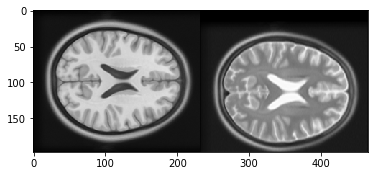

In [ ]:
t2_slice_moved = np.zeros(t2_slice.shape)
t2_slice_moved[15:, :] = t2_slice[:-15, :]
plt.imshow(np.hstack((t1_slice, t2_slice_moved)))

Now the scatterplot is a lot more diffuse:



Text(0.5, 1.0, 'T1 vs T2 signal after moving T2 image')

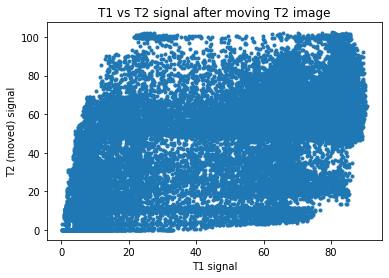

In [ ]:
plt.plot(t1_slice.ravel(), t2_slice_moved.ravel(), '.')
plt.xlabel('T1 signal')
plt.ylabel('T2 (moved) signal')
plt.title('T1 vs T2 signal after moving T2 image')

The joint (2D) histogram shows the same thing. Because the signal is less concentrated into a small number of bins, the mutual information has dropped:

mutual information after transformation:  0.4577827377824529


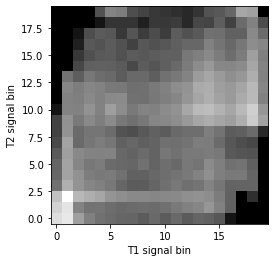

In [ ]:
hist_2d_moved, x_edges, y_edges = np.histogram2d(t1_slice.ravel(),t2_slice_moved.ravel(),bins=20)
# Show log histogram, avoiding divide by 0
hist_2d_moved_log = np.zeros(hist_2d_moved.shape)
non_zeros = hist_2d_moved != 0
hist_2d_moved_log[non_zeros] = np.log(hist_2d_moved[non_zeros])
plt.imshow(hist_2d_moved_log.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')
print("mutual information after transformation: ", mutual_information(hist_2d_moved))

# Readings

* [1997, Paul Viola and William M. Wells III, Alignment by Maximization of Mutual Information, Int. Jour. of Computer Vision, 24(2) pg 137–154, 1997](http://people.csail.mit.edu/sw/papers/IJCV-97.pdf)

* [Viola PhD](https://dspace.mit.edu/bitstream/handle/1721.1/9918/40073866-MIT.pdf?sequence=2&isAllowed=y)